In [1]:
import torch
from torch import nn, optim, autograd
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from dataclasses import dataclass
import time
import sys
%matplotlib inline
torch.set_num_threads(1)
torch.manual_seed(1)

In [2]:
print(f"python Version: {sys.version.split(' ')[0]}")
print(f"torch Version: {torch.__version__}")
print(f"torchvision Version: {torchvision.__version__}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

python Version: 3.10.11
torch Version: 2.1.1+cu118
torchvision Version: 0.16.1+cu118
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
@dataclass
class Hyperparameter:
    num_classes: int        = 10
    batchsize: int          = 128
    num_epochs: int         = 20
    latent_size: int        = 32
    n_critic: int           = 5
    critic_size: int        = 1024
    generator_size: int     = 1024
    critic_hidden_size: int = 1024
    gp_lambda: float        = 10.
        
hp = Hyperparameter()

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.latent_embedding = nn.Sequential(
            nn.Linear(hp.latent_size, hp.generator_size // 2),
        )
        self.condition_embedding = nn.Sequential(
            nn.Linear(hp.num_classes, hp.generator_size // 2),
        )
        self.tcnn = nn.Sequential(
        nn.ConvTranspose2d( hp.generator_size, hp.generator_size, 4, 1, 0),
        nn.BatchNorm2d(hp.generator_size),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d( hp.generator_size, hp.generator_size // 2, 3, 2, 1),
        nn.BatchNorm2d(hp.generator_size // 2),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d( hp.generator_size // 2, hp.generator_size // 4, 4, 2, 1),
        nn.BatchNorm2d(hp.generator_size // 4),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d( hp.generator_size // 4, 1, 4, 2, 1),
        nn.Tanh()
        )
        
    def forward(self, latent, condition):
        vec_latent = self.latent_embedding(latent)
        vec_class = self.condition_embedding(condition)
        combined = torch.cat([vec_latent, vec_class], dim=1).reshape(-1, hp.generator_size, 1, 1)
        return self.tcnn(combined)

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.condition_embedding = nn.Sequential(
            nn.Linear(hp.num_classes, hp.critic_size * 4),
        )
        self.cnn_net = nn.Sequential(
        nn.Conv2d(1, hp.critic_size // 4, 3, 2),
        nn.InstanceNorm2d(hp.critic_size // 4, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(hp.critic_size // 4, hp.critic_size // 2, 3, 2),
        nn.InstanceNorm2d(hp.critic_size // 2, affine=True),
        nn.LeakyReLU(0.2, inplace=True),   
        nn.Conv2d(hp.critic_size // 2, hp.critic_size, 3, 2),
        nn.InstanceNorm2d(hp.critic_size, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Flatten(),
        )
        self.Critic_net = nn.Sequential(
        nn.Linear(hp.critic_size * 8, hp.critic_hidden_size),
        nn.LeakyReLU(0.2, inplace=True),   
        nn.Linear(hp.critic_hidden_size, 1),
        )
        
    def forward(self, image, condition):
        vec_condition = self.condition_embedding(condition)
        cnn_features = self.cnn_net(image)
        combined = torch.cat([cnn_features, vec_condition], dim=1)
        return self.Critic_net(combined)


In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
                                
dataset  = torchvision.datasets.MNIST("mnist", download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=hp.batchsize, num_workers=1,
                                         shuffle=True, drop_last=True, pin_memory=True)

critic, generator = Critic().to("cuda"), Generator().to("cuda")

critic_optimizer = optim.AdamW(critic.parameters(), lr=1e-4,betas=(0., 0.9))
generator_optimizer = optim.AdamW(generator.parameters(), lr=1e-4,betas=(0., 0.9))

100%|██████████| 9912422/9912422 [00:02<00:00, 3713348.45it/s]


Extracting mnist\MNIST\raw\train-images-idx3-ubyte.gz to mnist\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 4124891.68it/s]


Extracting mnist\MNIST\raw\train-labels-idx1-ubyte.gz to mnist\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2113034.90it/s]


Extracting mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to mnist\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist\MNIST\raw


In [6]:
img_list, generator_losses, critic_losses = [], [], []
iters = 0
all_labels = torch.eye(hp.num_classes, dtype=torch.float32, device="cuda")
fixed_noise = torch.randn((80, hp.latent_size), device="cuda")
fixed_class_labels = all_labels[[i for i in list(range(hp.num_classes)) for idx in range(8)]]
grad_tensor = torch.ones((hp.batchsize, 1), device="cuda")

start_time = time.time()
for epoch in range(hp.num_epochs):
    for batch_idx, data in enumerate(dataloader, 0):
        real_images, real_class_labels = data[0].to("cuda"), all_labels[data[1]].to("cuda")
        
        # Update critic
        critic_optimizer.zero_grad()
        
        critic_output_real = critic(real_images, real_class_labels)
        critic_loss_real = critic_output_real.mean()

        noise = torch.randn((hp.batchsize, hp.latent_size), device="cuda")
        with torch.no_grad(): fake_image = generator(noise, real_class_labels)
        critic_output_fake = critic(fake_image, real_class_labels)
        critic_loss_fake = critic_output_fake.mean()

        alpha = torch.rand((hp.batchsize, 1), device="cuda")
        interpolates = (alpha.view(-1, 1, 1, 1) * real_images + ((1. - alpha.view(-1, 1, 1, 1)) * fake_image)).requires_grad_(True)
        d_interpolates = critic(interpolates, real_class_labels)
        gradients = autograd.grad(d_interpolates, interpolates, grad_tensor, create_graph=True, only_inputs=True)[0]
        gradient_penalty = hp.gp_lambda * ((gradients.view(hp.batchsize, -1).norm(dim=1) - 1.) ** 2).mean()

        critic_loss = -critic_loss_real + critic_loss_fake  + gradient_penalty
        
        critic_loss.backward()
        critic_optimizer.step()

        if batch_idx % hp.n_critic == 0:
            # Update Generator
            generator_optimizer.zero_grad()
            
            fake_class_labels = all_labels[torch.randint(hp.num_classes, size=[hp.batchsize])]
            noise = torch.randn((hp.batchsize, hp.latent_size), device="cuda")
            fake_image = generator(noise, fake_class_labels)
            critic_output_fake = critic(fake_image, fake_class_labels)
            generator_loss = -critic_output_fake.mean()
            
            generator_loss.backward()
            generator_optimizer.step()
        
        # Output training stats
        if batch_idx % 100 == 0:
            elapsed_time = time.time() - start_time
            print(f"[{epoch:>2}/{hp.num_epochs}][{iters:>7}][{elapsed_time:8.2f}s]\t"
                  f"d_loss/g_loss: {critic_loss.item():4.2}/{generator_loss.item():4.2}\t")
       
        # Save Losses for plotting later
        generator_losses.append(generator_loss.item())
        critic_losses.append(critic_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == hp.num_epochs - 1) and (batch_idx == len(dataloader) - 1)):
            with torch.no_grad(): fake_images = generator(fixed_noise, fixed_class_labels).cpu()
            img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
            
        iters += 1

[ 0/20][      0][    2.92s]	d_loss/g_loss:  3.2/0.17	
[ 0/20][    100][   17.97s]	d_loss/g_loss: -5.9/0.29	
[ 0/20][    200][   33.42s]	d_loss/g_loss: -6.1/ 1.5	
[ 0/20][    300][   48.68s]	d_loss/g_loss: -5.8/0.88	
[ 0/20][    400][   64.03s]	d_loss/g_loss: -3.1/-2.6	
[ 1/20][    468][   77.35s]	d_loss/g_loss: -3.5/-1.3	
[ 1/20][    568][   92.60s]	d_loss/g_loss: -3.3/-2.9	
[ 1/20][    668][  107.79s]	d_loss/g_loss: -3.1/-4.1	
[ 1/20][    768][  123.24s]	d_loss/g_loss: -2.6/-4.5	
[ 1/20][    868][  138.73s]	d_loss/g_loss: -2.1/-3.6	
[ 2/20][    936][  151.76s]	d_loss/g_loss: -1.4/-4.8	
[ 2/20][   1036][  167.24s]	d_loss/g_loss: -1.6/-5.3	
[ 2/20][   1136][  182.73s]	d_loss/g_loss: -1.5/-1.9	
[ 2/20][   1236][  198.24s]	d_loss/g_loss: -0.77/-3.2	
[ 2/20][   1336][  213.79s]	d_loss/g_loss: -0.83/-4.3	
[ 3/20][   1404][  226.93s]	d_loss/g_loss: -0.66/-2.9	
[ 3/20][   1504][  242.46s]	d_loss/g_loss: -1.2/-2.3	
[ 3/20][   1604][  257.98s]	d_loss/g_loss: -1.4/-2.9	
[ 3/20][   1704][  273.51

In [7]:
torch.save(generator.state_dict(), f'/Generator_Epoch.pth')
torch.save(critic.state_dict(), f'/Discriminator_Epoch.pth')

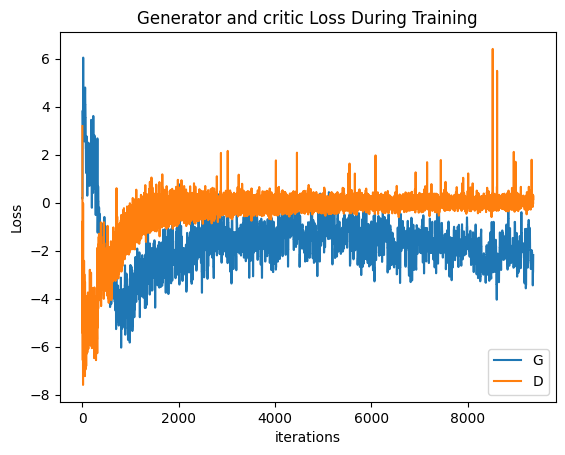

In [8]:
plt.title("Generator and critic Loss During Training")
plt.plot(generator_losses,label="G")
plt.plot(critic_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

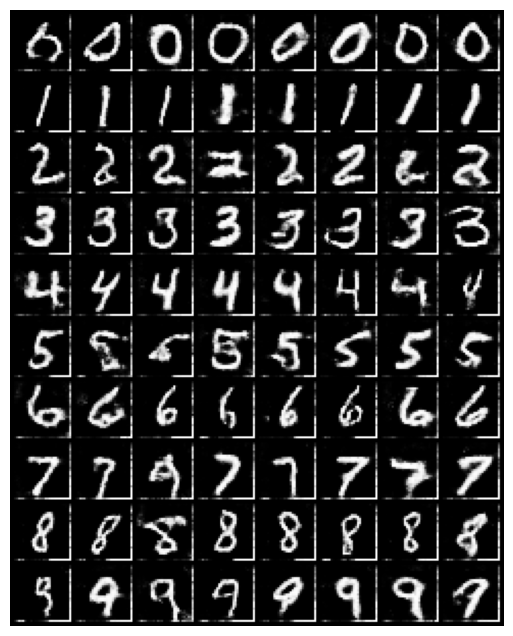

In [11]:
import matplotlib.animation as animation
from IPython.display import HTML
##%%capture
fig = plt.figure(figsize=(10,8))
plt.axis("off")
ims = [[plt.imshow(i.permute(1,2,0), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=2,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('scatter.gif', writer=writer)
HTML(ani.to_jshtml())